# Sistema de detección de enlaces spam

### Cargamos la data

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
df_urls = pd.read_csv(url)

# Mostrar las primeras filas
df_urls.head()


,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


## Análisis exploratorio inicial

In [2]:
# Tamaño del dataset
print("Shape del dataset:", df_urls.shape)

# Info general
df_urls.info()

# Conteo de valores nulos
print("\nValores nulos por columna:")
print(df_urls.isnull().sum())

# Distribución de clases (spam vs. no spam)
print("\nDistribución de clases:")
print(df_urls['is_spam'].value_counts())


Shape del dataset: (2999, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB

Valores nulos por columna:
url        0
is_spam    0
dtype: int64

Distribución de clases:
is_spam
False    2303
True      696
Name: count, dtype: int64


### Visualización de la distribución de clases

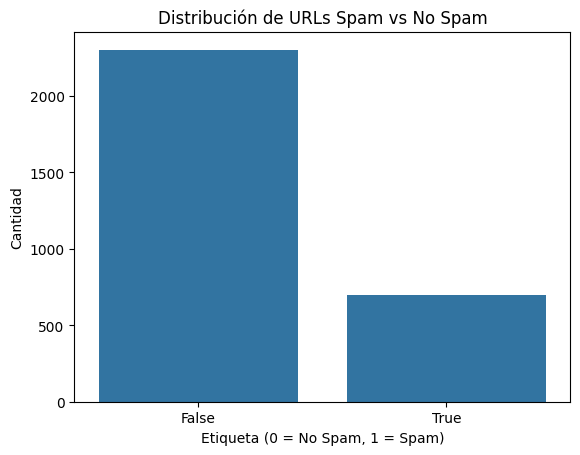

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df_urls, x='is_spam')
plt.title("Distribución de URLs Spam vs No Spam")
plt.xlabel("Etiqueta (0 = No Spam, 1 = Spam)")
plt.ylabel("Cantidad")
plt.show()

### Preprocesamiento del texto (URLs)

In [9]:
import pandas as pd
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Descargas necesarias
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar dataset
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')

# Preprocesamiento de URLs
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_url(url):
    # Minúsculas
    url = url.lower()
    # Reemplazar signos por espacios
    url = re.sub(r'[\/:.\-=?&%_]', ' ', url)
    # Eliminar cualquier carácter no alfabético
    url = re.sub(r'[^a-z ]', ' ', url)
    # Tokenizar
    tokens = url.split()
    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_url'] = df['url'].apply(preprocess_url)

# Vectorización
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['clean_url'])
y = df['is_spam']

# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Análisis sobre las URLs ya procesadas

Longitud promedio de tokens por URL: 9.67889296432144


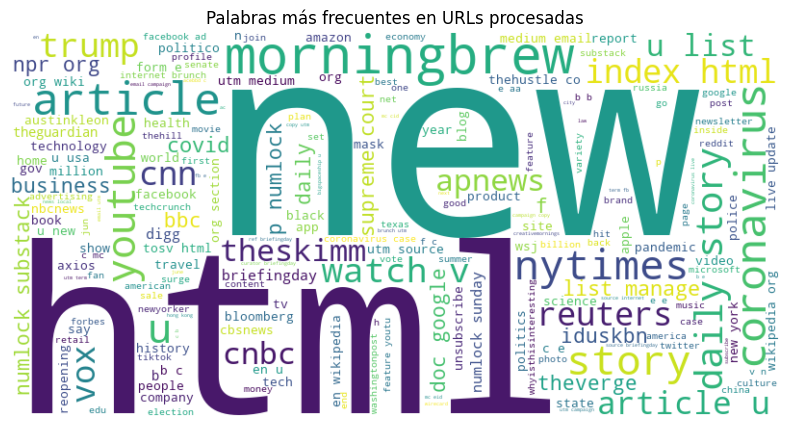

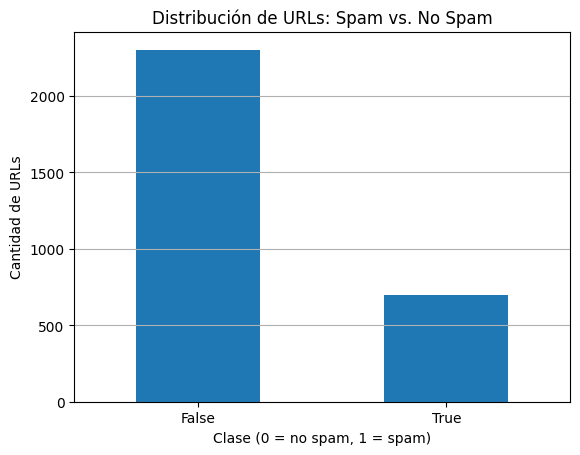

In [13]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Longitud promedio del texto procesado
df['token_count'] = df['clean_url'].apply(lambda x: len(x.split()))
print("Longitud promedio de tokens por URL:", df['token_count'].mean())

# Wordcloud de términos frecuentes
text_all = " ".join(df['clean_url'].tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes en URLs procesadas')
plt.show()

# Distribución de clases
df['is_spam'].value_counts().plot(kind='bar')
plt.title("Distribución de URLs: Spam vs. No Spam")
plt.xlabel("Clase (0 = no spam, 1 = spam)")
plt.ylabel("Cantidad de URLs")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


##  Entrenamiento de un modelo SVM con parámetros por defecto

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Entrenar modelo SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predicciones
y_pred = svm_model.predict(X_test)

# Métricas
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))


Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.96      0.98      0.97       455
        True       0.94      0.88      0.91       145

    accuracy                           0.96       600
   macro avg       0.95      0.93      0.94       600
weighted avg       0.96      0.96      0.96       600

Matriz de confusión:
 [[447   8]
 [ 18 127]]


## Hiperparametrización del modelo SVM

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Modelo base (SVM sin optimización)
from sklearn.svm import SVC

model_svm = SVC()  # modelo con hiperparámetros por defecto
model_svm.fit(X_train, y_train)

# Entrenar GridSearch con SVM
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Modelo óptimo
best_svm = grid_search.best_estimator_

# Predicciones
y_pred_base = model_svm.predict(X_test)
y_pred_opt = best_svm.predict(X_test)

## Matrices de confusión hiperparametrizada vs por defecto

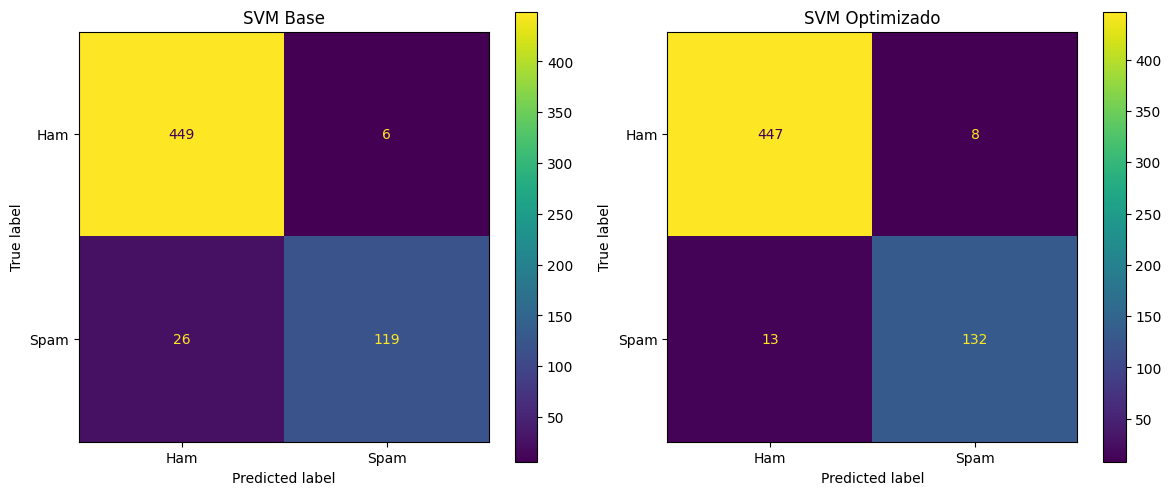

Reporte del modelo optimizado:

              precision    recall  f1-score   support

         Ham       0.97      0.98      0.98       455
        Spam       0.94      0.91      0.93       145

    accuracy                           0.96       600
   macro avg       0.96      0.95      0.95       600
weighted avg       0.96      0.96      0.96       600



In [17]:
# Comparar matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz base
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_base), display_labels=['Ham', 'Spam']).plot(ax=axes[0])
axes[0].set_title("SVM Base")

# Matriz optimizada
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_opt), display_labels=['Ham', 'Spam']).plot(ax=axes[1])
axes[1].set_title("SVM Optimizado")

plt.tight_layout()
plt.show()

# Reporte
print("Reporte del modelo optimizado:\n")
print(classification_report(y_test, y_pred_opt, target_names=["Ham", "Spam"]))

### Guardar el mejor modelo


In [19]:
joblib.dump(best_svm, "/workspaces/LucasDellaMaestra-NLP/models/mejor_svm_model.pkl")
print("✅ Modelo optimizado guardado como 'mejor_svm_model.pkl'")

✅ Modelo optimizado guardado como 'mejor_svm_model.pkl'
